In [1]:
import numpy as np
import scipy.io as sio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import csv
import os
import json
import math

from glob import glob
from collections import defaultdict
from scipy import signal
import matplotlib.pyplot as plt

In [2]:
jsonFileName = './inputJson/test.json'

f = open(jsonFileName)
inputJson = json.load(f)
dataPathBase = inputJson['dataPathBase']
dataType = inputJson['dataType']
f.close()

print(dataType)
if dataType == 'survey':
    fs = 1000 # 1 kHz
    nSubC = 30
    nRX = 3
    
    winLen = 1000
    thres = 60
    slideLen = 400

    # activities = ['bed']
    activities = ['bed', 'fall', 'pickup', 'run', 'sitdown', 'standup', 'walk']

survey


## Slice CSI data with windowing

In [3]:
if dataType == "survey":
    dataPath = dataPathBase + "HAR_survey/"
    dataDict = {activity:[] for activity in activities}
    for activity in activities:
        dataDict[activity] = defaultdict(list)
    windDataPath = dataPath + "window/"


elif dataType == "SHARP":
    dataPath = dataPathBase + "HAR_SHARP/"

for activity in activities:
    if dataType == "survey":
        fileNameList = glob(dataPath + "/input_" + activity + "*.csv")
        outputXXFileName = windDataPath + "xx_" + str(winLen) + "_" + str(thres) + "_" + activity + ".csv"
        outputYYFileName = windDataPath + "yy_" + str(winLen) + "_" + str(thres) + "_" + activity + ".csv"
    print('Processing', activity+", # of files:", len(fileNameList))

    xx = np.empty([0, winLen, nSubC*nRX], float)
    yy = np.empty([0,8], float)
    for fileIndex, fileName in enumerate(fileNameList):
        data = np.array([[float(elm) for elm in v] for v in csv.reader(open(fileName, 'r'))])
        x2 = np.empty([0, winLen, nSubC*nRX], float)
        # print(data.shape, end=' ')

        k = 0
        while k <= (len(data) + 1 - 2*winLen):
            x = np.dstack(data[k:k+winLen, 1:1+nSubC*nRX].T)
            x2 = np.concatenate((x2, x), axis=0)
            k += slideLen
        # print(x2.shape, end=' ')
        xx = np.concatenate((xx, x2), axis=0)

        annotFileName = fileName.replace('input', 'annotation')
        annot = np.array([[str(elm) for elm in v] for v in csv.reader(open(annotFileName, 'r'))])
        # print(len(annot), end= ' ')
        y = np.zeros(((len(annot) + 1 - 2 * winLen)//slideLen+1,8))
        k = 0
        while k <= (len(annot) + 1 - 2 * winLen):
            y_pre = np.stack(np.array(annot[k:k+winLen]))
            bed = 0
            fall = 0
            walk = 0
            pickup = 0
            run = 0
            sitdown = 0
            standup = 0
            noactivity = 0
            for j in range(winLen):
                if y_pre[j] == "bed":
                    bed += 1
                elif y_pre[j] == "fall":
                    fall += 1
                elif y_pre[j] == "walk":
                    walk += 1
                elif y_pre[j] == "pickup":
                    pickup += 1
                elif y_pre[j] == "run":
                    run += 1
                elif y_pre[j] == "sitdown":
                    sitdown += 1
                elif y_pre[j] == "standup":
                    standup += 1
                else:
                    noactivity += 1

            if bed > winLen * thres / 100:
                y[int(k/slideLen),:] = np.array([0,1,0,0,0,0,0,0])
            elif fall > winLen * thres / 100:
                y[int(k/slideLen),:] = np.array([0,0,1,0,0,0,0,0])
            elif walk > winLen * thres / 100:
                y[int(k/slideLen),:] = np.array([0,0,0,1,0,0,0,0])
            elif pickup > winLen * thres / 100:
                y[int(k/slideLen),:] = np.array([0,0,0,0,1,0,0,0])
            elif run > winLen * thres / 100:
                y[int(k/slideLen),:] = np.array([0,0,0,0,0,1,0,0])
            elif sitdown > winLen * thres / 100:
                y[int(k/slideLen),:] = np.array([0,0,0,0,0,0,1,0])
            elif standup > winLen * thres / 100:
                y[int(k/slideLen),:] = np.array([0,0,0,0,0,0,0,1])
            else:
                y[int(k/slideLen),:] = np.array([2,0,0,0,0,0,0,0])
            k += slideLen
        # print(y.shape)
        yy = np.concatenate((yy, y),axis=0)

    xx = xx.reshape(len(xx), -1)
    print(xx.shape, yy.shape)

    with open(outputXXFileName, "w") as f:
        writer = csv.writer(f)
        writer.writerows(xx)
    with open(outputYYFileName, "w") as f:
        writer = csv.writer(f)
        writer.writerows(yy)


Processing bed, # of files: 79
(3556, 90000) (3556, 8)
Processing fall, # of files: 79
(3556, 90000) (3556, 8)
Processing pickup, # of files: 80
(3600, 90000) (3600, 8)
Processing run, # of files: 80
(3590, 90000) (3590, 8)
Processing sitdown, # of files: 80
(3598, 90000) (3598, 8)
Processing standup, # of files: 79
(3556, 90000) (3556, 8)
Processing walk, # of files: 80
(3600, 90000) (3600, 8)


In [47]:
csvFileName = '/project/iarpa/wifiHAR/HAR_survey_window/temp.csv'
num_lines = sum(1 for l in open(csvFileName))
print(num_lines)

90


In [3]:
if dataType == "survey":
    dataPath = dataPathBase + "HAR_survey/"
    dataDict = {activity:[] for activity in activities}
    for activity in activities:
        dataDict[activity] = defaultdict(list)

elif dataType == "SHARP":
    dataPath = dataPathBase + "HAR_SHARP/"

for subFolder in os.walk(dataPath):
    if dataType == "survey":
        fileNameList = glob(subFolder[0] + "/input*.csv")
    print(len(fileNameList))
    
    for fileIndex, fileDirName in enumerate(fileNameList):
        fileName = fileDirName.split('/')[-1]
        fileType = fileName.split('_')[0]
        fileActv = fileName.split('_')[1]
        if fileActv not in activities:
            continue

        annotFileName = "annotation" + fileName[5:]
        annotFileDirName = subFolder[0] + annotFileName

        with open(fileDirName, mode='r') as file:
            csiData = list(csv.reader(file))
            csiDataNP = np.array(csiData).astype(np.float32)
            
        with open(annotFileDirName, mode='r') as annotFile:
            annotData = list(csv.reader(annotFile))
            annotDataNP = np.array(annotData)

        dataDict[fileActv]['CSI'].append(csiDataNP)
        dataDict[fileActv]['annot'].append(annotDataNP)

for activity in activities:
    print(activity, len(dataDict[activity]['annot']))

557
bed 79
fall 79
pickup 80
run 80
sitdown 80
standup 79
walk 80


In [4]:
for activity in activities:
    print('Checking annotation integrity of', activity, 'data')
    for dataInd in range(len(dataDict[activity]['annot'])):
        actDetected = 0
        for i in range(len(dataDict[activity]['annot'][dataInd])):
            # print(dataDict['run']['annot'][dataInd][i])
            if dataDict[activity]['annot'][dataInd][i] == activity:
                actDetected = 1
            elif actDetected == 1 and dataDict[activity]['annot'][dataInd][i] == 'NoActivity':
                actDetected = 2
            elif actDetected == 2 and dataDict[activity]['annot'][dataInd][i] == activity:
                print(activity, dataInd) # two activities in one file
                break

Checking annotation integrity of bed data
Checking annotation integrity of fall data
Checking annotation integrity of pickup data
Checking annotation integrity of run data
Checking annotation integrity of sitdown data
Checking annotation integrity of standup data
Checking annotation integrity of walk data


## Compute average length of activities

In [10]:
# activity = 'bed'
for activity in activities:
    actDurationSum = 0
    for dataInd in range(len(dataDict[activity]['annot'])):
        actDetected = 0
        minActStart = 0
        maxActEnd = 20000
        for i in range(len(dataDict[activity]['annot'][dataInd])):
            if actDetected == 0 and dataDict[activity]['annot'][dataInd][i] == activity:
                actDetected = 1
                actStart = i
            elif actDetected == 1 and dataDict[activity]['annot'][dataInd][i] == 'NoActivity':
                actEnd = i
                actDurationSum += (actEnd - actStart)
                print(dataInd, (actEnd - actStart), end=' ')
                # , math.floor((actEnd+actStart)/2)
                break
        if dataInd % 20 == 19 and dataInd != len(dataDict[activity]['annot'][dataInd])-1:
            print()
    print()
    actDurationAvg = actDurationSum / len(dataDict[activity]['annot'])
    print(activity, actDurationAvg)
    print()

0 7619 1 8359 2 8199 3 7489 4 8119 5 7379 6 7359 7 7814 8 6964 9 7829 10 8794 11 7644 12 7739 13 7649 14 8664 15 8249 16 8309 17 7744 18 9964 19 8184 
20 7634 21 7274 22 8659 23 8489 24 8404 25 7714 26 7409 27 7984 28 7404 29 9879 30 9599 31 8509 32 8289 33 7849 34 8709 35 7964 36 6784 37 7609 38 7164 39 7919 
40 8169 41 7804 42 8154 43 6724 44 7539 45 8134 46 7474 47 7974 48 7964 49 7224 50 7214 51 7604 52 7319 53 7474 54 8834 55 8274 56 7934 57 7244 58 8329 59 8094 
60 7299 61 8179 62 6804 63 8649 64 6859 65 7694 66 8134 67 7714 68 6539 69 6984 70 7434 71 8814 72 9134 73 7409 74 7504 75 7929 76 7889 77 8759 78 6714 
bed 3528.974683544304

0 6994 1 6324 2 7304 3 7189 4 6649 5 9119 6 6819 7 7639 8 6999 9 7629 10 7164 11 6764 12 7539 13 6484 14 8029 15 7874 16 7384 17 7729 18 7599 19 7724 
20 6674 21 5204 22 6699 23 6239 24 6729 25 6914 26 6284 27 6594 28 7509 29 7309 30 7424 31 8049 32 7034 33 7669 34 8154 35 5964 36 6404 37 7844 38 5889 39 7274 
40 7509 41 7559 42 6439 43 8664 44 7654

## Data visualization

5969 10270 

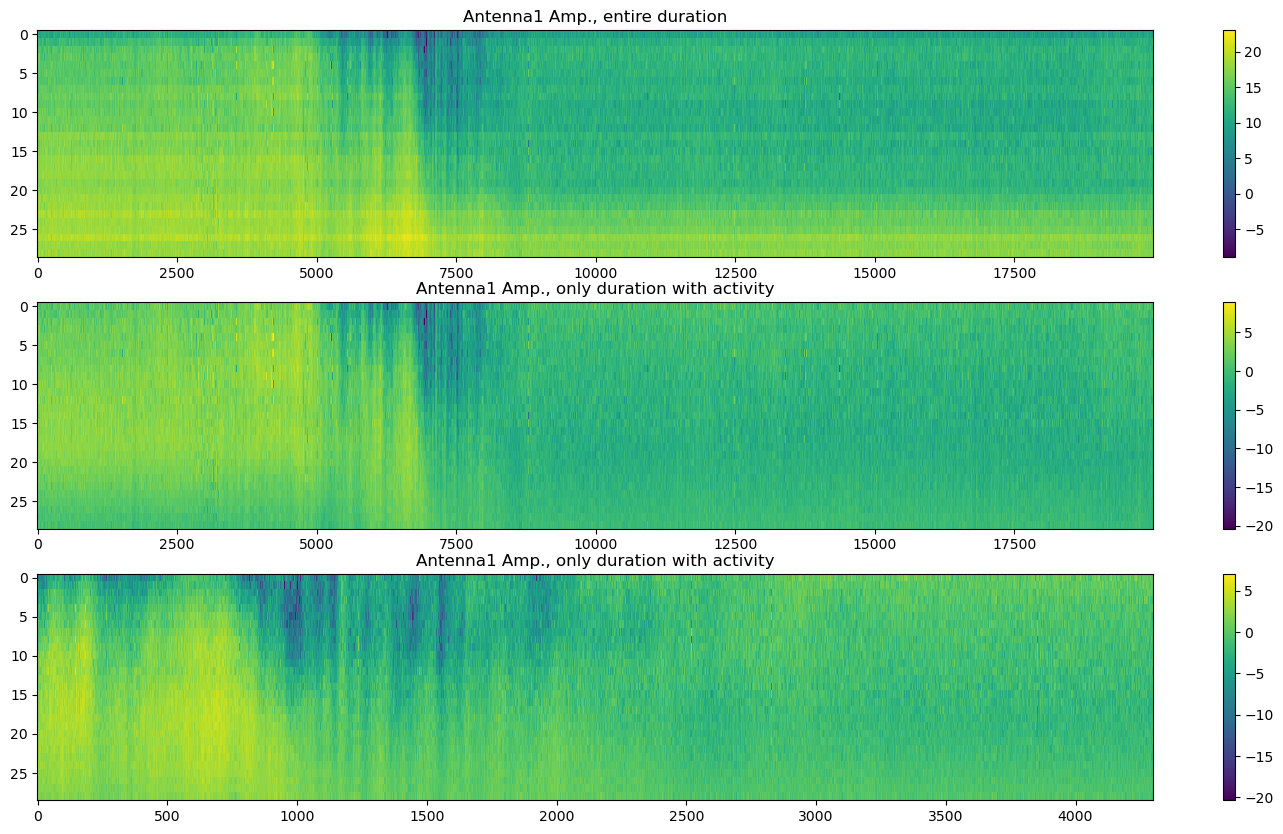

In [8]:
# for dataInd in range(len(dataDict[activity]['CSI'])):
activity = 'bed'
dataInd = 4

actDetected = 0
for i in range(len(dataDict[activity]['annot'][dataInd])):
    if actDetected == 0 and dataDict[activity]['annot'][dataInd][i] == activity:
        actDetected = 1
        actStart = i
    elif actDetected == 1 and dataDict[activity]['annot'][dataInd][i] == 'NoActivity':
        actEnd = i
        print(actStart, actEnd, end=' ')
        break

RXInd = 0
dataAmp = dataDict[activity]['CSI'][dataInd][:, 1:91]
fig = plt.figure(figsize = (18,10))
ax1 = plt.subplot(311)
plt.imshow(np.transpose(dataAmp[:, (RXInd*nSubC):(RXInd*nSubC+29)]), interpolation='nearest', aspect='auto')
ax1.set_title("Antenna1 Amp., entire duration")
plt.colorbar()

dataAmpNorm = dataAmp - np.mean(dataAmp, axis=0)
ax1 = plt.subplot(312)
plt.imshow(np.transpose(dataAmpNorm[:, (RXInd*nSubC):(RXInd*nSubC+29)]), interpolation='nearest', aspect='auto')
ax1.set_title("Antenna1 Amp., only duration with activity")
plt.colorbar()

ax1 = plt.subplot(313)
plt.imshow(np.transpose(dataAmpNorm[actStart:actEnd, (RXInd*nSubC):(RXInd*nSubC+29)]), interpolation='nearest', aspect='auto')
ax1.set_title("Antenna1 Amp., only duration with activity")
plt.colorbar()


# for i in range(1, len(dataAmpNorm[0])):
#     filtered_data[:,i] = moving_average(dataAmpNorm[:,i], 100)


In [52]:
def moving_average(data, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')
